In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

file_path = '/content/sample_data/Sales_Tzs_April_2024_Nov_2025.xlsx'
Kemondo_Sales = pd.read_excel(file_path)
Kemondo_Sales.index = pd.to_datetime(Kemondo_Sales.index)


print(Kemondo_Sales.head())

                                    Date     Sales
1970-01-01 00:00:00.000000000 2021-08-06  191840.0
1970-01-01 00:00:00.000000001 2021-08-07  343280.0
1970-01-01 00:00:00.000000002 2021-08-09  311720.0
1970-01-01 00:00:00.000000003 2021-08-10  358750.0
1970-01-01 00:00:00.000000004 2021-08-11  173410.0


# **Step 1: Bulk Sales Distribution**

STEP 1: IDENTIFYING MISSING BUSINESS DAYS

Dataset date range: 2021-08-06 to 2025-11-13

Total calendar days in range: 1561
Expected business days: 1308
Existing dates in dataset: 1179
Missing business days: 162

First 10 missing dates: ['2021-12-25', '2022-02-19', '2022-02-22', '2022-03-04', '2022-03-05', '2022-03-19', '2022-04-20', '2022-09-23', '2024-03-27', '2024-04-02']

STEP 2: CREATING COMPLETE DATASET

Complete dataset created with 1319 business days
Days with zero sales: 167

STEP 3: BUILDING MONTHLY WEEKDAY WEIGHTS FROM 2023

Using 291 normal days from 2023 for weight calculation
(Excluded: spikes >= 2,000,000 and low sales < 100,000)

Sample weights (Month, Weekday -> Average Sales):
  Month 1, Mon: 511,419 TZS
  Month 1, Tue: 174,370 TZS
  Month 1, Wed: 342,175 TZS
  Month 1, Thu: 232,325 TZS
  Month 1, Fri: 274,275 TZS
  Month 1, Sat: 210,856 TZS
  Month 2, Mon: 487,391 TZS
  Month 2, Tue: 459,094 TZS
  Month 2, Wed: 382,607 TZS
  Month 2, Thu: 197,540 TZS

STEP 4: IDENTIF

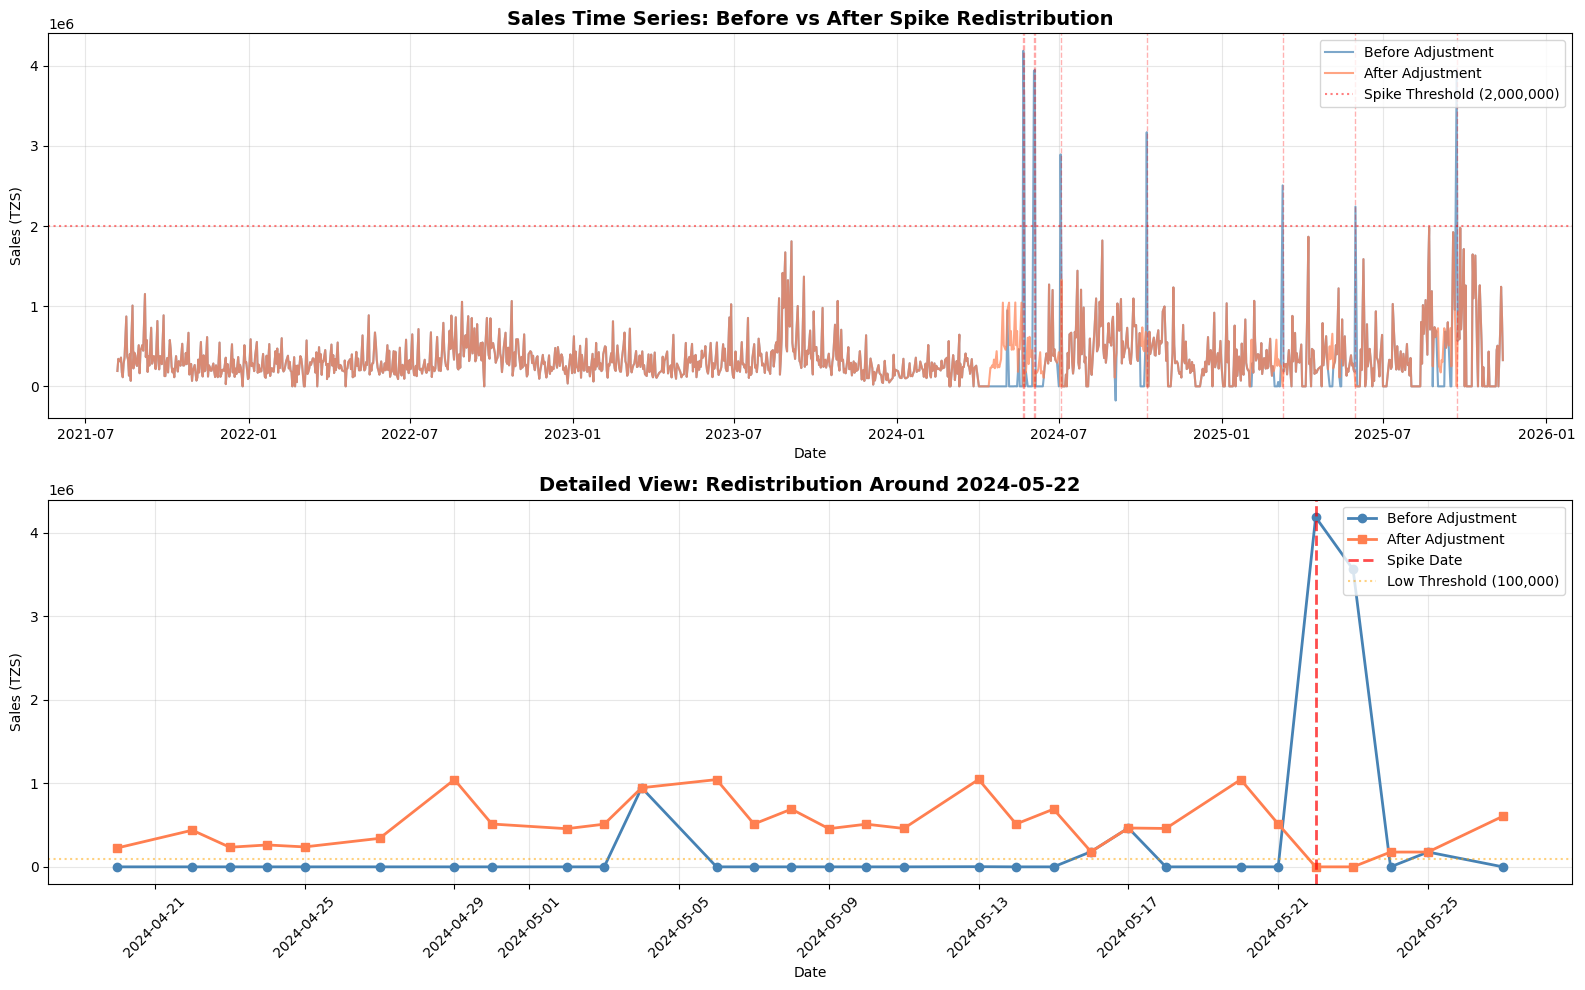


✓ Visualization complete

FINAL SUMMARY

Total sales before adjustment: 452,611,834.31 TZS
Total sales after adjustment: 452,611,834.31 TZS
Difference: 0.00 TZS

Spikes redistributed: 9
Missing business days added: 162
Final dataset size: 1319 business days


In [ ]:


# Defining Terms

SPIKE_THRESHOLD = 2_000_000
LOW_THRESHOLD = 100_000
LOOKBACK_DAYS = 30
REFERENCE_YEAR = 2023

# Tanzanian Public Holidays
TANZANIAN_HOLIDAYS = [
    # 2023
    '2023-01-01', '2023-01-12', '2023-04-07', '2023-04-10', '2023-04-26',
    '2023-05-01', '2023-07-07', '2023-08-08', '2023-10-14', '2023-12-09',
    '2023-12-25', '2023-12-26',
    # 2024
    '2024-01-01', '2024-01-12', '2024-03-29', '2024-04-01', '2024-04-26',
    '2024-05-01', '2024-07-07', '2024-08-08', '2024-10-14', '2024-12-09',
    '2024-12-25', '2024-12-26',
    # 2025
    '2025-01-01', '2025-01-12', '2025-04-18', '2025-04-21', '2025-04-26',
    '2025-05-01', '2025-07-07', '2025-08-08', '2025-10-14', '2025-12-09',
    '2025-12-25', '2025-12-26',
]


# STEP 1: IDENTIFYING MISSING VALUES (BUSINESS DAYS ONLY)


def identify_missing_business_days(df, date_col='Date'):
    """
    Identifies missing dates that fall on business days (Mon-Sat, excluding holidays)
    """
    print("=" * 70)
    print("STEP 1: IDENTIFYING MISSING BUSINESS DAYS")
    print("=" * 70)

    # Convert to datetime
    df[date_col] = pd.to_datetime(df[date_col])

    # Get date range
    start_date = df[date_col].min()
    end_date = df[date_col].max()

    print(f"\nDataset date range: {start_date.date()} to {end_date.date()}")

    # Create complete date range
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Filter for business days (Mon-Sat, excluding holidays)
    business_days = []
    for date in all_dates:
        is_sunday = date.weekday() == 6
        is_holiday = date.strftime('%Y-%m-%d') in TANZANIAN_HOLIDAYS

        if not is_sunday and not is_holiday:
            business_days.append(date)

    # Find missing business days
    existing_dates = set(df[date_col])
    missing_dates = [date for date in business_days if date not in existing_dates]

    print(f"\nTotal calendar days in range: {len(all_dates)}")
    print(f"Expected business days: {len(business_days)}")
    print(f"Existing dates in dataset: {len(existing_dates)}")
    print(f"Missing business days: {len(missing_dates)}")

    if missing_dates:
        print(f"\nFirst 10 missing dates: {[d.strftime('%Y-%m-%d') for d in missing_dates[:10]]}")

    return business_days, missing_dates

business_days, missing_dates = identify_missing_business_days(Kemondo_Sales)


# STEP 2: CREATING A COMPLETE DATASET WITH MISSING DAYS AS ZERO


def create_complete_dataset(df, business_days, date_col='Date', sales_col='Sales'):
    """
    Adds missing business days to dataset with sales = 0
    """
    print("\n" + "=" * 70)
    print("STEP 2: CREATING COMPLETE DATASET")
    print("=" * 70)

    # Create dataframe with all business days
    complete_df = pd.DataFrame({'Date': business_days})

    # Merge with existing data
    df_complete = complete_df.merge(
        df[[date_col, sales_col]],
        left_on='Date',
        right_on=date_col,
        how='left'
    )

    # Drop duplicate date column if exists
    if date_col in df_complete.columns and date_col != 'Date':
        df_complete = df_complete.drop(columns=[date_col])

    # Rename to standard column name
    df_complete = df_complete.rename(columns={'Date': date_col})

    # Fill missing sales with 0
    df_complete[sales_col] = df_complete[sales_col].fillna(0)

    # Sort by date
    df_complete = df_complete.sort_values(date_col).reset_index(drop=True)

    print(f"\nComplete dataset created with {len(df_complete)} business days")
    print(f"Days with zero sales: {(df_complete[sales_col] == 0).sum()}")

    return df_complete

Kemondo_Sales_complete = create_complete_dataset(Kemondo_Sales, business_days)


# STEP 3: BUILDING MONTHLY WEEKDAY WEIGHTS FROM 2023


def build_monthly_weekday_weights(df, date_col='Date', sales_col='Sales', reference_year=2023):
    """
    Calculates average sales weights for each weekday in each month from reference year
    """
    print("\n" + "=" * 70)
    print(f"STEP 3: BUILDING MONTHLY WEEKDAY WEIGHTS FROM {reference_year}")
    print("=" * 70)

    df_ref = df[df[date_col].dt.year == reference_year].copy()

    # Filtering out spikes and very low values for weight calculation
    normal_mask = (
        (df_ref[sales_col] < SPIKE_THRESHOLD) &
        (df_ref[sales_col] >= LOW_THRESHOLD)
    )
    df_normal = df_ref[normal_mask].copy()

    print(f"\nUsing {len(df_normal)} normal days from {reference_year} for weight calculation")
    print(f"(Excluded: spikes >= {SPIKE_THRESHOLD:,} and low sales < {LOW_THRESHOLD:,})")

    # Adding month and weekday
    df_normal['month'] = df_normal[date_col].dt.month
    df_normal['weekday'] = df_normal[date_col].dt.dayofweek
    df_normal['weekday_name'] = df_normal[date_col].dt.day_name()

    # Calculating average sales per weekday per month
    weights = df_normal.groupby(['month', 'weekday', 'weekday_name'])[sales_col].mean().reset_index()
    weights = weights.rename(columns={sales_col: 'avg_sales'})

    # Creating weight dictionary
    weight_dict = {}
    for _, row in weights.iterrows():
        weight_dict[(row['month'], row['weekday'])] = row['avg_sales']

    # Displaying sample weights
    print("\nSample weights (Month, Weekday -> Average Sales):")
    for key in list(weight_dict.keys())[:10]:
        month, weekday = key
        weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        print(f"  Month {month}, {weekday_names[weekday]}: {weight_dict[key]:,.0f} TZS")

    return weight_dict

monthly_weights = build_monthly_weekday_weights(Kemondo_Sales_complete)


# STEP 4: IDENTIFYING SPIKES AND THEIR REDISTRIBUTION WINDOWS

def identify_spikes_and_windows_continuous(df, date_col='Date', sales_col='Sales'):
    """
    Modified version: includes ALL previous days in lookback, not just until normal sales
    """
    print("\n" + "=" * 70)
    print("STEP 4: IDENTIFYING SPIKES (CONTINUOUS WINDOW)")
    print("=" * 70)

    spikes = []
    spike_mask = df[sales_col] > SPIKE_THRESHOLD
    spike_indices = df[spike_mask].index.tolist()

    print(f"\nFound {len(spike_indices)} spikes")

    for spike_idx in spike_indices:
        spike_row = df.iloc[spike_idx]
        spike_date = spike_row[date_col]
        spike_amount = spike_row[sales_col]

        # Looking back and collect ALL days below threshold
        window_indices = []

        for i in range(1, LOOKBACK_DAYS + 1):
            lookback_idx = spike_idx - i

            if lookback_idx < 0:
                break

            lookback_row = df.iloc[lookback_idx]
            lookback_sales = lookback_row[sales_col]

            # Including this day if it's below threshold
            if lookback_sales < LOW_THRESHOLD:
                window_indices.append(lookback_idx)

        if window_indices:
            spikes.append({
                'spike_idx': spike_idx,
                'spike_date': spike_date,
                'spike_amount': spike_amount,
                'window_indices': window_indices,
                'window_size': len(window_indices)
            })

            print(f"\nSpike on {spike_date.strftime('%Y-%m-%d')}: {spike_amount:,.0f} TZS")
            print(f"  Redistribution window: {len(window_indices)} eligible days in last {LOOKBACK_DAYS} days")

    return spikes





# STEP 5: REDISTRIBUTING SPIKES USING MONTHLY WEEKDAY WEIGHTS


def redistribute_spikes(df, spikes_info, weights, date_col='Date', sales_col='Sales'):
    """
    Redistributes each spike across its window using monthly weekday weights
    """
    print("\n" + "=" * 70)
    print("STEP 5: REDISTRIBUTING SPIKES")
    print("=" * 70)

    df_adjusted = df.copy()

    for spike in spikes_info:
        spike_idx = spike['spike_idx']
        spike_date = spike['spike_date']
        spike_amount = spike['spike_amount']
        window_indices = spike['window_indices']

        print(f"\nRedistributing spike on {spike_date.strftime('%Y-%m-%d')}...")

        # Getting month for weight lookup
        month = spike_date.month

        # Calculating weights for each day in window
        window_weights = []
        for idx in window_indices:
            day_date = df_adjusted.loc[idx, date_col]
            weekday = day_date.weekday()

            # Getting weight from dictionary (default to 1.0 if not found)
            weight = weights.get((month, weekday), 1.0)
            window_weights.append(weight)

        # Normalizing weights
        total_weight = sum(window_weights)
        if total_weight == 0:
            # back to equal distribution
            window_weights = [1.0] * len(window_indices)
            total_weight = len(window_indices)

        normalized_weights = [w / total_weight for w in window_weights]

        # Redistributing spike amount
        for idx, norm_weight in zip(window_indices, normalized_weights):
            redistribution_amount = spike_amount * norm_weight
            df_adjusted.loc[idx, sales_col] += redistribution_amount

            day_date = df_adjusted.loc[idx, date_col]
            print(f"  {day_date.strftime('%Y-%m-%d')}: +{redistribution_amount:,.0f} TZS")

        # Zero out the spike
        df_adjusted.loc[spike_idx, sales_col] = 0
        print(f"  Spike day set to 0")

    return df_adjusted


spikes_info = identify_spikes_and_windows_continuous(Kemondo_Sales_complete)
Kemondo_Sales_adjusted = redistribute_spikes(
    Kemondo_Sales_complete,
    spikes_info,
    monthly_weights
)


# STEP 6: VISUALIZING RESULTS


def visualize_adjustment(df_original, df_adjusted, spikes_info, date_col='Date', sales_col='Sales'):
    """
    Creates comprehensive visualization of the adjustment process
    """
    print("\n" + "=" * 70)
    print("STEP 6: CREATING VISUALIZATIONS")
    print("=" * 70)

    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Plot 1: Full time series comparison
    axes[0].plot(df_original[date_col], df_original[sales_col],
                 label='Before Adjustment', alpha=0.7, color='steelblue', linewidth=1.5)
    axes[0].plot(df_adjusted[date_col], df_adjusted[sales_col],
                 label='After Adjustment', alpha=0.7, color='coral', linewidth=1.5)

    # Mark spike dates
    for spike in spikes_info:
        axes[0].axvline(x=spike['spike_date'], color='red', linestyle='--',
                       alpha=0.3, linewidth=1)

    axes[0].axhline(y=SPIKE_THRESHOLD, color='red', linestyle=':',
                   label=f'Spike Threshold ({SPIKE_THRESHOLD:,})', alpha=0.5)
    axes[0].set_title('Sales Time Series: Before vs After Spike Redistribution',
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales (TZS)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
        # Plot 2: Zoomed view of first spike
    if spikes_info:
        spike = spikes_info[0]
        spike_date = spike['spike_date']
        window_size = spike['window_size']

        start_zoom = spike_date - pd.Timedelta(days=window_size + 5)
        end_zoom = spike_date + pd.Timedelta(days=5)

        zoom_mask = (df_adjusted[date_col] >= start_zoom) & (df_adjusted[date_col] <= end_zoom)
        zoom_original = df_original[zoom_mask]
        zoom_adjusted = df_adjusted[zoom_mask]

        axes[1].plot(zoom_original[date_col], zoom_original[sales_col],
                    marker='o', label='Before Adjustment', linewidth=2,
                    markersize=6, color='steelblue')
        axes[1].plot(zoom_adjusted[date_col], zoom_adjusted[sales_col],
                    marker='s', label='After Adjustment', linewidth=2,
                    markersize=6, color='coral')

        axes[1].axvline(x=spike_date, color='red', linestyle='--',
                       label='Spike Date', linewidth=2, alpha=0.7)
        axes[1].axhline(y=LOW_THRESHOLD, color='orange', linestyle=':',
                       label=f'Low Threshold ({LOW_THRESHOLD:,})', alpha=0.5)

        axes[1].set_title(f'Detailed View: Redistribution Around {spike_date.strftime("%Y-%m-%d")}',
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Sales (TZS)')
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n✓ Visualization complete")

visualize_adjustment(Kemondo_Sales_complete, Kemondo_Sales_adjusted, spikes_info)


# STEP 7: SUMMARY STATISTICS


print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"\nTotal sales before adjustment: {Kemondo_Sales_complete['Sales'].sum():,.2f} TZS")
print(f"Total sales after adjustment: {Kemondo_Sales_adjusted['Sales'].sum():,.2f} TZS")
print(f"Difference: {abs(Kemondo_Sales_complete['Sales'].sum() - Kemondo_Sales_adjusted['Sales'].sum()):,.2f} TZS")

print(f"\nSpikes redistributed: {len(spikes_info)}")
print(f"Missing business days added: {len(missing_dates)}")
print(f"Final dataset size: {len(Kemondo_Sales_adjusted)} business days")



# **HANDLING MISSING VALUES**


STEP 8: FORWARD FILLING MISSING VALUES (BUSINESS DAYS)

Zero values before forward fill: 108

Zero values after forward fill: 0
Values filled: 108

Sample of filled values:
  2021-12-25: 0 → 134,000 TZS
  2022-02-19: 0 → 182,480 TZS
  2022-02-22: 0 → 364,240 TZS
  2022-03-04: 0 → 129,200 TZS
  2022-03-05: 0 → 129,200 TZS
  2022-03-19: 0 → 424,400 TZS
  2022-04-20: 0 → 322,400 TZS
  2022-09-23: 0 → 229,300 TZS
  2024-02-29: 0 → 564,500 TZS
  2024-03-01: 0 → 161,000 TZS

STEP 9: VISUALIZING FORWARD FILL IMPACT


/tmp/ipython-input-2276454102.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled[sales_col] = df_filled[sales_col].fillna(method='ffill')


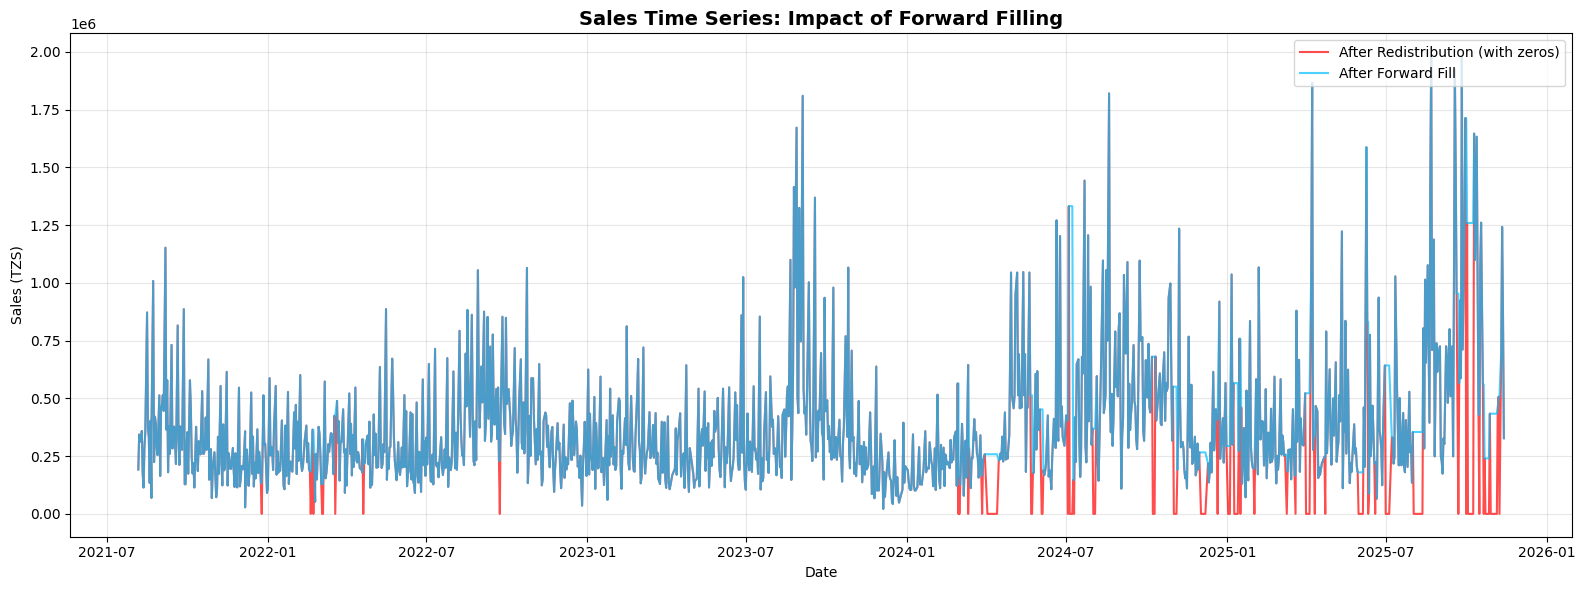


✓ Visualization complete

COMPLETE PROCESSING SUMMARY

1. MISSING VALUES HANDLING:
   - Missing business days added: 162
   - Initial zero values: 108
   - Final zero values: 0
   - Values forward filled: 108

2. SPIKE REDISTRIBUTION:
   - Spikes detected: N/A
   - Spikes redistributed: 9

3. DATASET STATISTICS:
   - Total business days: 1319
   - Date range: 2021-08-06 to 2025-11-13
   - Total sales: 503,594,760.18 TZS
   - Average daily sales: 381,800.42 TZS
   - Median daily sales: 294,500.00 TZS


In [ ]:

# HANDLING MISSING VALUES WITH FORWARD FILL


def forward_fill_business_days(df, date_col='Date', sales_col='Sales'):
    """
    Forward fills zero values on business days
    Treats negative values as 0 first, then applies forward fill
    """
    print("\n" + "=" * 70)
    print("STEP 8: FORWARD FILLING MISSING VALUES (BUSINESS DAYS)")
    print("=" * 70)

    df_filled = df.copy()

    # Step 1: Replacing negative values with 0
    negative_count = (df_filled[sales_col] < 0).sum()
    if negative_count > 0:
        print(f"\nFound {negative_count} negative values - setting to 0")
        df_filled.loc[df_filled[sales_col] < 0, sales_col] = 0

    # Step 2: Counting zeros before filling
    zero_count_before = (df_filled[sales_col] == 0).sum()
    print(f"\nZero values before forward fill: {zero_count_before}")

    # Step 3: Applying forward fill
    df_filled[sales_col] = df_filled[sales_col].replace(0, np.nan)
    df_filled[sales_col] = df_filled[sales_col].fillna(method='ffill')

    # Step 4: Handling any remaining NaN at the beginning (use backward fill)
    remaining_nan = df_filled[sales_col].isna().sum()
    if remaining_nan > 0:
        print(f"\nWarning: {remaining_nan} values at start of dataset have no previous value")
        print("Applying backward fill for these cases...")
        df_filled[sales_col] = df_filled[sales_col].fillna(method='bfill')

    # Step 5: Final check - replace any remaining NaN with 0 (safety net)
    df_filled[sales_col] = df_filled[sales_col].fillna(0)

    # Count zeros after filling
    zero_count_after = (df_filled[sales_col] == 0).sum()
    filled_count = zero_count_before - zero_count_after

    print(f"\nZero values after forward fill: {zero_count_after}")
    print(f"Values filled: {filled_count}")

    # Showing examples of filled values
    if filled_count > 0:
        print("\nSample of filled values:")
        filled_mask = (df[sales_col] == 0) & (df_filled[sales_col] > 0)
        sample_filled = df_filled[filled_mask].head(10)

        for idx, row in sample_filled.iterrows():
            original_val = df.loc[idx, sales_col]
            filled_val = row[sales_col]
            date_str = row[date_col].strftime('%Y-%m-%d')
            print(f"  {date_str}: {original_val:,.0f} → {filled_val:,.0f} TZS")

    return df_filled

# Applying forward fill
Kemondo_Sales_final = forward_fill_business_days(Kemondo_Sales_adjusted)


# STEP 2: VISUALIZING BEFORE AND AFTER FORWARD FILL


def visualize_forward_fill(df_before, df_after, date_col='Date', sales_col='Sales'):
    """
    Visualizes the impact of forward filling
    """
    print("\n" + "=" * 70)
    print("STEP 9: VISUALIZING FORWARD FILL IMPACT")
    print("=" * 70)

    fig, ax = plt.subplots(figsize=(16, 6))

    # Full time series comparison
    ax.plot(df_before[date_col], df_before[sales_col],
            label='After Redistribution (with zeros)', alpha=0.7,
            color='red', linewidth=1.5)
    ax.plot(df_after[date_col], df_after[sales_col],
            label='After Forward Fill', alpha=0.7,
            color='deepskyblue', linewidth=1.5)
    ax.set_title('Sales Time Series: Impact of Forward Filling',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales (TZS)')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✓ Visualization complete")

visualize_forward_fill(Kemondo_Sales_adjusted, Kemondo_Sales_final)

# FINAL SUMMARY AND EXPORT

print("\n" + "=" * 70)
print("COMPLETE PROCESSING SUMMARY")
print("=" * 70)

print("\n1. MISSING VALUES HANDLING:")
print(f"   - Missing business days added: {len(missing_dates)}")
print(f"   - Initial zero values: {(Kemondo_Sales_adjusted['Sales'] == 0).sum()}")
print(f"   - Final zero values: {(Kemondo_Sales_final['Sales'] == 0).sum()}")
print(f"   - Values forward filled: {(Kemondo_Sales_adjusted['Sales'] == 0).sum() - (Kemondo_Sales_final['Sales'] == 0).sum()}")

print("\n2. SPIKE REDISTRIBUTION:")
print(f"   - Spikes detected: {len(spike_indices) if 'spike_indices' in locals() else 'N/A'}")
print(f"   - Spikes redistributed: {len(spikes_info)}")

print("\n3. DATASET STATISTICS:")
print(f"   - Total business days: {len(Kemondo_Sales_final)}")
print(f"   - Date range: {Kemondo_Sales_final['Date'].min().date()} to {Kemondo_Sales_final['Date'].max().date()}")
print(f"   - Total sales: {Kemondo_Sales_final['Sales'].sum():,.2f} TZS")
print(f"   - Average daily sales: {Kemondo_Sales_final['Sales'].mean():,.2f} TZS")
print(f"   - Median daily sales: {Kemondo_Sales_final['Sales'].median():,.2f} TZS")




In [ ]:
# LOG TRANSFORMATION


# Applied

In [ ]:
Kemondo_Sales_final = pd.read_excel('/content/sample_data/Kemondo_Sales_final.xlsx')


# **AGGREGATION**

/tmp/ipython-input-1922032064.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = Kemondo_Sales_final.set_index('Date').resample('M')['Sales'].sum().reset_index()


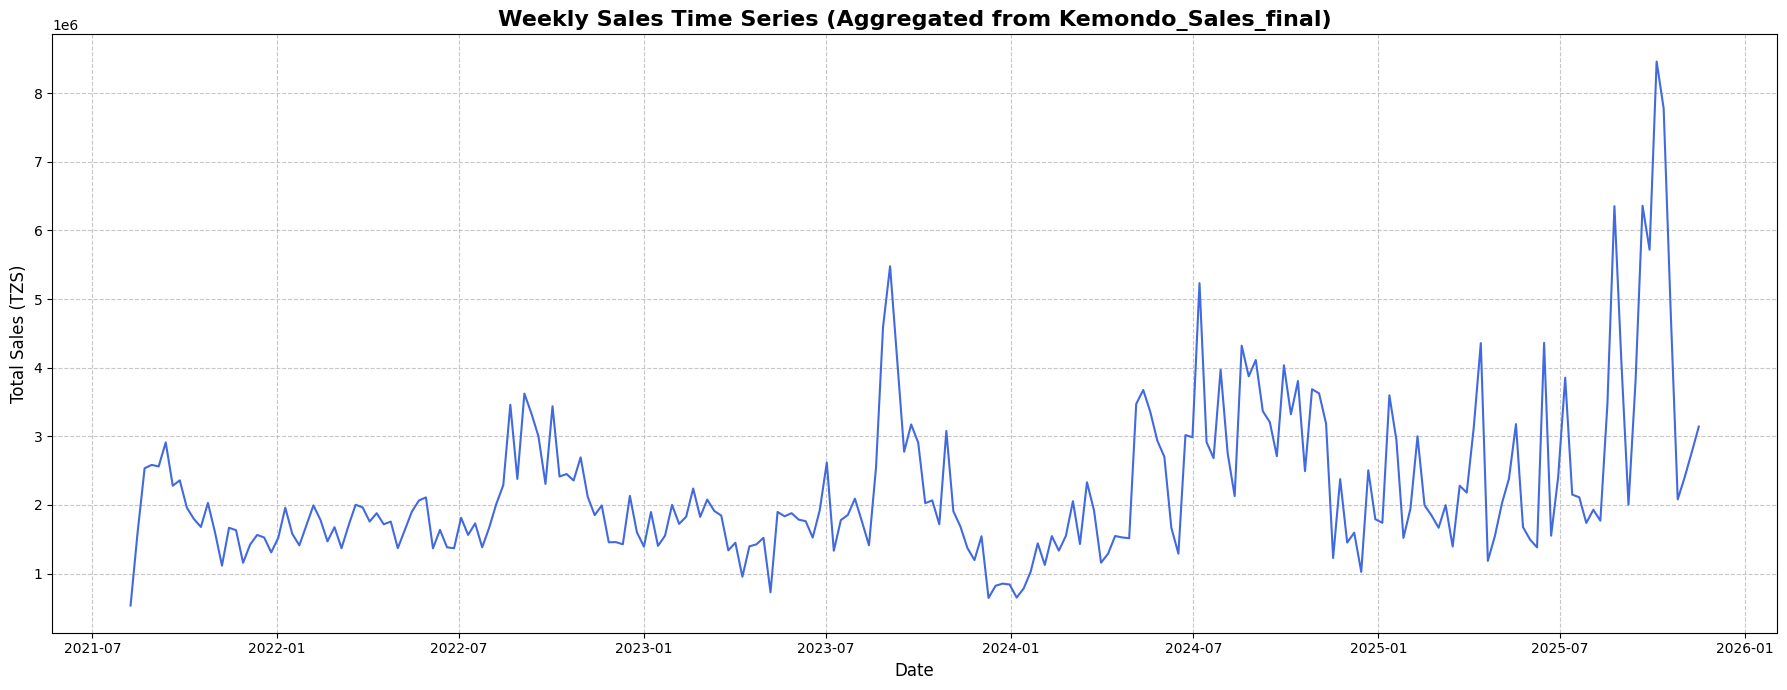

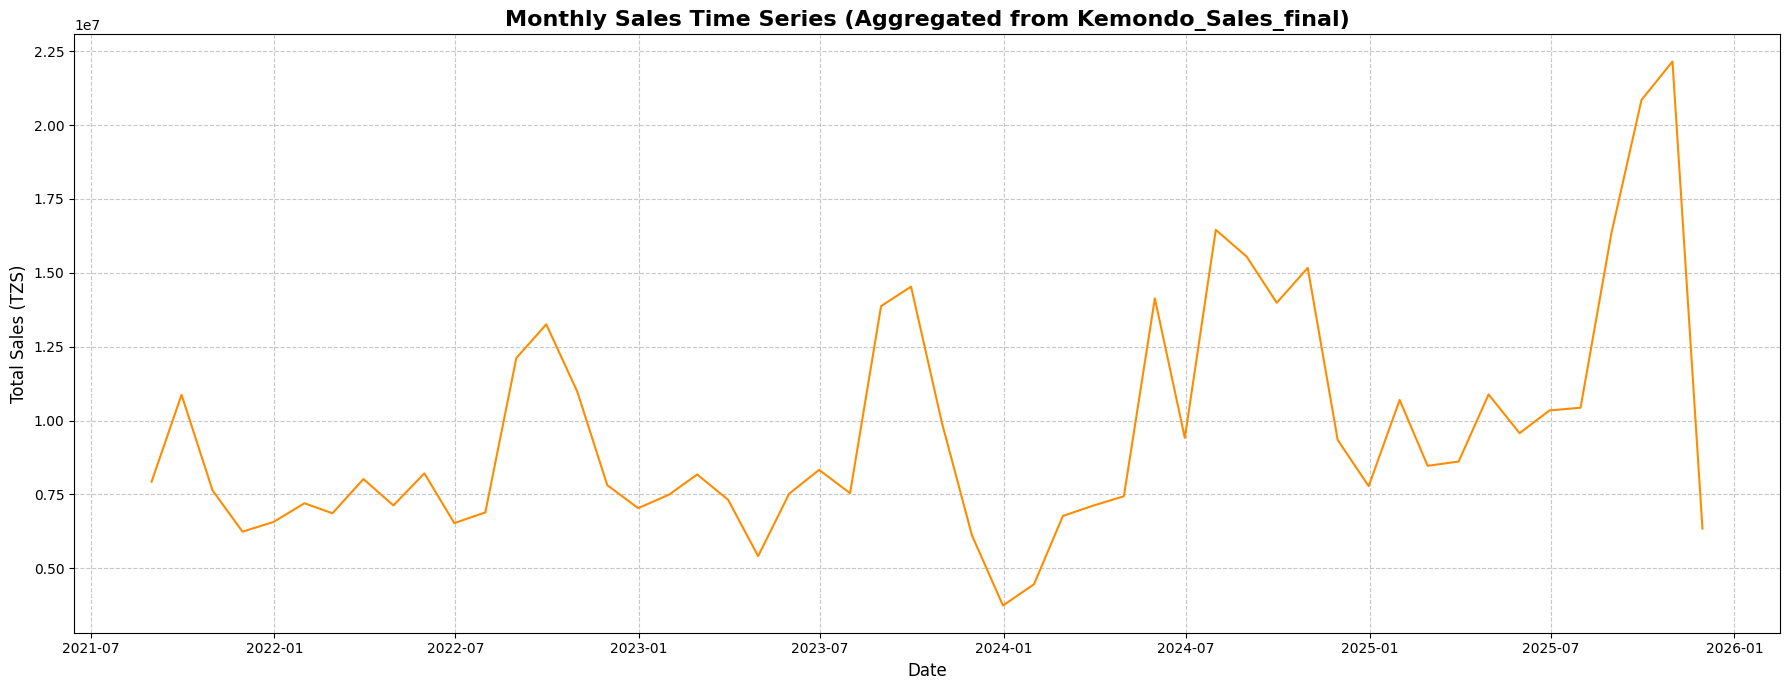


Weekly Sales (first 5 rows):


,Date,Sales
0,2021-08-08,535120.0
1,2021-08-15,1598517.5
2,2021-08-22,2535590.0
3,2021-08-29,2583585.0
4,2021-09-05,2561950.0



Monthly Sales (first 5 rows):


,Date,Sales
0,2021-08-31,7929402.50
1,2021-09-30,10872400.00
2,2021-10-31,7637137.50
3,2021-11-30,6239950.00
4,2021-12-31,6568134.97


In [ ]:



# --- Weekly Time Series Aggregation ---
weekly_sales = Kemondo_Sales_final.set_index('Date').resample('W')['Sales'].sum().reset_index()

# --- Monthly Time Series Aggregation ---
monthly_sales = Kemondo_Sales_final.set_index('Date').resample('M')['Sales'].sum().reset_index()

# --- Plotting Weekly Time Series ---
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=weekly_sales, color='royalblue', linewidth=1.5)
plt.title('Weekly Sales Time Series (Aggregated from Kemondo_Sales_final)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plotting Monthly Time Series ---
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=monthly_sales, color='darkorange', linewidth=1.5)
plt.title('Monthly Sales Time Series (Aggregated from Kemondo_Sales_final)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nWeekly Sales (first 5 rows):")
display(weekly_sales.head())
print("\nMonthly Sales (first 5 rows):")
display(monthly_sales.head())

# **SPLITTING DATA**

In [ ]:
# --- Split Weekly Sales Data ---

# Calculate the split point (80% for training, 20% for testing)
split_point_weekly = int(len(weekly_sales) * 0.8)

# Split the weekly data
weekly_train = weekly_sales.iloc[:split_point_weekly]
weekly_test = weekly_sales.iloc[split_point_weekly:]

print("\n--- Weekly Sales Data Split ---")
print(f"Weekly Training Data Shape: {weekly_train.shape}")
print(f"Weekly Training Data Date Range: {weekly_train['Date'].min().strftime('%Y-%m-%d')} to {weekly_train['Date'].max().strftime('%Y-%m-%d')}")
print(f"Weekly Test Data Shape: {weekly_test.shape}")
print(f"Weekly Test Data Date Range: {weekly_test['Date'].min().strftime('%Y-%m-%d')} to {weekly_test['Date'].max().strftime('%Y-%m-%d')}")

# --- Split Monthly Sales Data ---

# Calculate the split point (80% for training, 20% for testing)
split_point_monthly = int(len(monthly_sales) * 0.8)

# Split the monthly data
monthly_train = monthly_sales.iloc[:split_point_monthly]
monthly_test = monthly_sales.iloc[split_point_monthly:]

print("\n--- Monthly Sales Data Split ---")
print(f"Monthly Training Data Shape: {monthly_train.shape}")
print(f"Monthly Training Data Date Range: {monthly_train['Date'].min().strftime('%Y-%m-%d')} to {monthly_train['Date'].max().strftime('%Y-%m-%d')}")
print(f"Monthly Test Data Shape: {monthly_test.shape}")
print(f"Monthly Test Data Date Range: {monthly_test['Date'].min().strftime('%Y-%m-%d')} to {monthly_test['Date'].max().strftime('%Y-%m-%d')}")



--- Weekly Sales Data Split ---
Weekly Training Data Shape: (179, 2)
Weekly Training Data Date Range: 2021-08-08 to 2025-01-05
Weekly Test Data Shape: (45, 2)
Weekly Test Data Date Range: 2025-01-12 to 2025-11-16

--- Monthly Sales Data Split ---
Monthly Training Data Shape: (41, 2)
Monthly Training Data Date Range: 2021-08-31 to 2024-12-31
Monthly Test Data Shape: (11, 2)
Monthly Test Data Date Range: 2025-01-31 to 2025-11-30


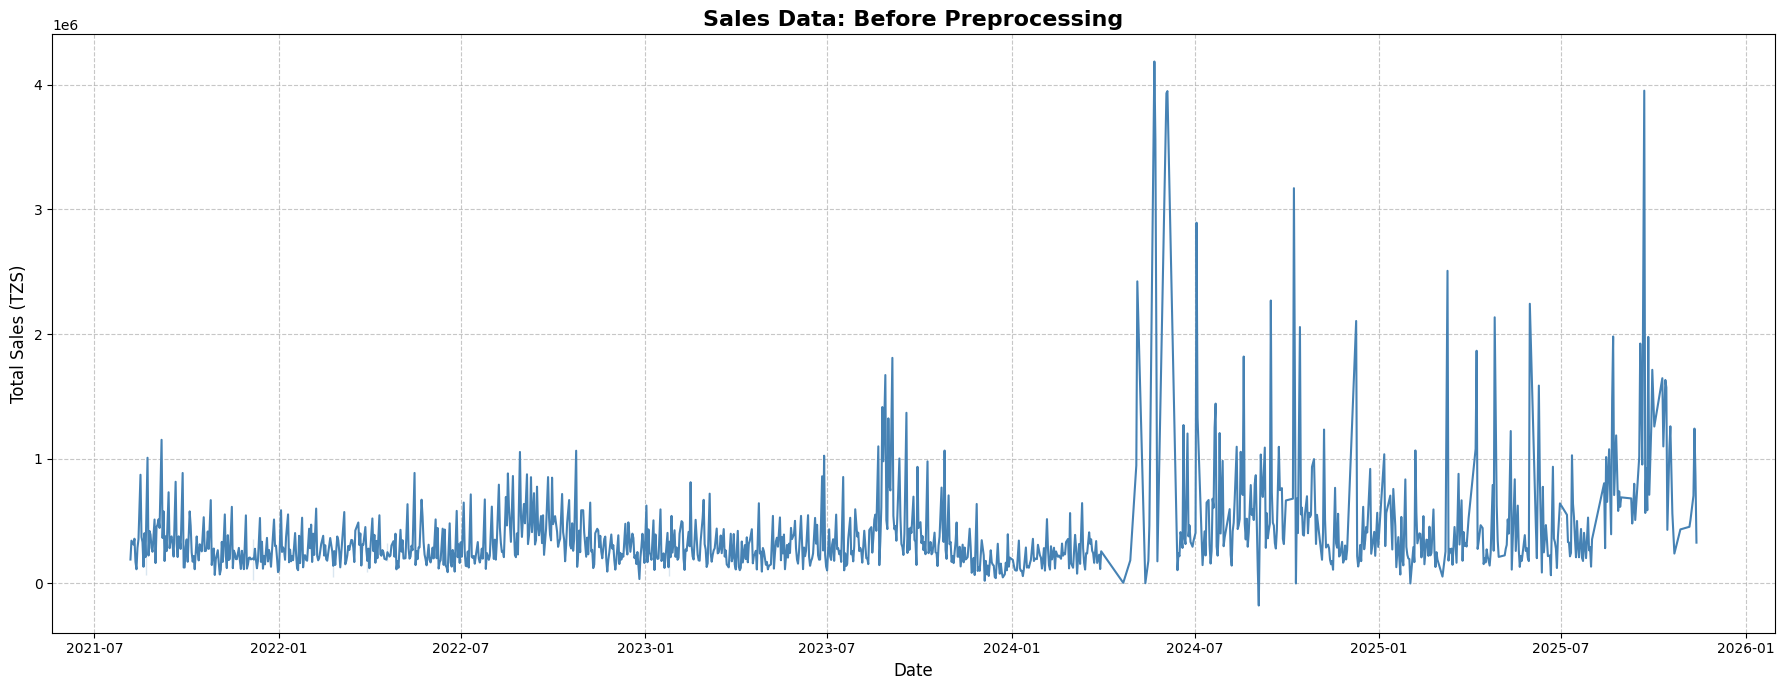

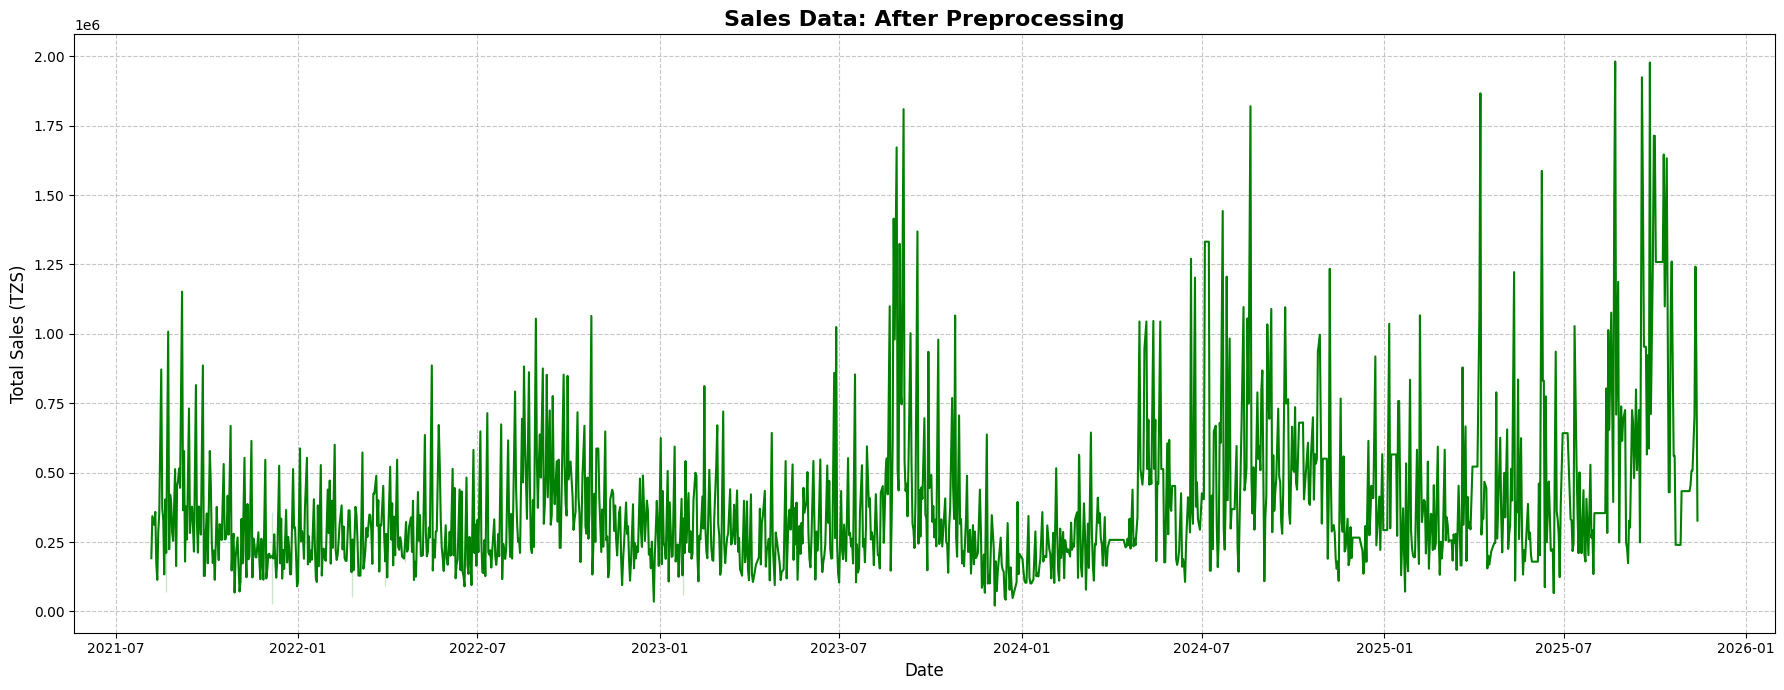

In [ ]:


# Kemondo_Sales (Before preprocessing)
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=Kemondo_Sales, color='steelblue', linewidth=1.5)
plt.title('Sales Data: Before Preprocessing', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Kemondo_Sales_final (After preprocessing)
plt.figure(figsize=(18, 7))
sns.lineplot(x='Date', y='Sales', data=Kemondo_Sales_final, color='green', linewidth=1.5)
plt.title('Sales Data: After Preprocessing', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (TZS)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
!jupyter nbconvert --to html /content/sample_data/RandomForests.ipynb

[NbConvertApp] Converting notebook /content/sample_data/RandomForests.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 711996 bytes to /content/sample_data/RandomForests.html


In [4]:
!sudo apt-get clean
!sudo rm -rf /var/lib/apt/lists/*
!sudo apt-get update


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,297 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,677 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,

In [5]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [7]:
!jupyter nbconvert --to pdf /content/Forecasting_PreprocessedData_BT.ipynb

[NbConvertApp] Converting notebook /content/Forecasting_PreprocessedData_BT.ipynb to pdf
[NbConvertApp] Support files will be in Forecasting_PreprocessedData_BT_files/
[NbConvertApp] Making directory ./Forecasting_PreprocessedData_BT_files
[NbConvertApp] Writing 141176 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1328143 bytes to /content/Forecasting_PreprocessedData_BT.pdf
